Impact of factors on retention

Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
#import geopandas as gpd

Read turnover data from csv into a dataframe. Input the latest data available into "month" and "year"

In [4]:
#month = "february"
#year = "2023"
url = f'../01_data/processed_monthly_turnover.csv'
df = pd.read_csv(url, parse_dates=['month_year'])
#df = df.sort_values(by='Date')
#df = df.drop(['Joiner_FTE','SIP_HC','Benchmark group','ICS code','ICS name'],axis=1)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193650 entries, 0 to 193649
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   org_code     193650 non-null  object        
 1   staff_group  193650 non-null  object        
 2   month_year   193650 non-null  datetime64[ns]
 3   n            193650 non-null  float64       
 4   join_HC      124069 non-null  float64       
 5   join_FTE     124069 non-null  float64       
 6   leave_HC     125487 non-null  float64       
 7   leave_FTE    125487 non-null  float64       
 8   denom_HC     192694 non-null  float64       
 9   denom_FTE    192694 non-null  float64       
dtypes: datetime64[ns](1), float64(7), object(2)
memory usage: 14.8+ MB


Drop joiners data to create leavers dataframe. Drop CCGs and ICBs (optionally) drop some staff groups not of interest.

In [7]:

#staff_groups_todrop = ['Other staff or those with unknown classification','Managers','Senior managers','Central functions','Hotel, property & estates']
#df_leaver = df_leaver[~df_leaver['Staff group'].isin(staff_groups_todrop)]

#trust_types_todrop = ['Clinical Commissioning Group','Integrated Care Board']
#df_leaver = df[~df['Cluster group'].isin(trust_types_todrop)]

#df_leaver_acute = df_leaver[df_leaver['Cluster group'] == 'Acute']

#df_leaver.head()
df_leaver = df

The data show the full time equivalent (FTE) number of leavers by organisation and staff group for the previous 12-month period from the date. It also shows the number of staff in post (SIP) FTE averaged over the 12-month period to date.

Load data about local unemployment so we can use it as a regressor

In [5]:
url_r1 = '../01_data/ONS_localunemployment_monthly.csv'
df_r1 = pd.read_csv(url_r1, parse_dates=['Date'])

df_r1.head()

,Date,Region,NHSE region name,%,thousands
0,1992-04-01,East Midlands,Midlands,0.087,177
1,1992-04-01,East of England,East of England,0.079,210
2,1992-04-01,London,London,0.123,424
3,1992-04-01,North East,North East,0.122,146
4,1992-04-01,North West,North West,0.101,331


In [6]:
#df_r1['Date'] = df['Date'].dt.strftime('%Y-%m-%d')

# drop type thousands, only use %s
#df_r1 = df_r1[df_r1['Type'] != 'thousands']

df_r1.drop(['Region','thousands'],axis=1,inplace=True)
df_r1.rename(columns={'%':'local_unemployment'},inplace=True)
df_r1 = df_r1.sort_values('Date')
df_r1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3348 entries, 0 to 3347
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                3348 non-null   datetime64[ns]
 1   NHSE region name    3348 non-null   object        
 2   local_unemployment  3348 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 104.6+ KB


Add data about local unemployment at the regional level to the main dataframe

In [8]:
df_leaver_r1 = pd.merge(df_leaver, df_r1, on=['Date', 'NHSE region name'],how='left')
#df_leaver_r1 = df_leaver_r1.dropna()
df_leaver_r1.info()

KeyError: 'Date'

Load data about sickness absence to use as second regressor

In [7]:
url_r2 = '../01_data/sickness_absence.csv'
df_r2 = pd.read_csv(url_r2, parse_dates=['Date'])
trust_types_todrop = ['Clinical Commissioning Group','Integrated Care Board']
df_r2 = df_r2[~df_r2['Cluster group'].isin(trust_types_todrop)]
df_r2 = df_r2.drop('Benchmark group',axis=1)
df_r2 = df_r2.reset_index(drop=True)
df_r2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273083 entries, 0 to 273082
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   Date                273083 non-null  datetime64[ns]
 1   Org code            273083 non-null  object        
 2   Org name            273083 non-null  object        
 3   NHSE region code    273083 non-null  object        
 4   NHSE region name    273083 non-null  object        
 5   Cluster group       273083 non-null  object        
 6   Staff group         273083 non-null  object        
 7   FTE days lost       237915 non-null  float64       
 8   FTE days available  237915 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(6)
memory usage: 18.8+ MB


In [8]:
df_r2.head()

,Date,Org code,Org name,NHSE region code,NHSE region name,Cluster group,Staff group,FTE days lost,FTE days available
0,2018-03-01,RT3,Royal Brompton and Harefield NHS Foundation Trust,Y56,London,Acute,"Hotel, property & estates",202.97333,4692.62646
1,2018-03-01,0DE,NHS Arden and Greater East Midlands Commission...,QZZ,Special Health Authorities and other statutory...,Commissioning Support Unit,Managers,150.75336,7272.63377
2,2018-03-01,0DE,NHS Arden and Greater East Midlands Commission...,QZZ,Special Health Authorities and other statutory...,Commissioning Support Unit,Nurses & health visitors,35.64000,2327.04646
3,2018-03-01,0DE,NHS Arden and Greater East Midlands Commission...,QZZ,Special Health Authorities and other statutory...,Commissioning Support Unit,"Scientific, therapeutic & technical staff",10.39998,504.83363
4,2018-03-01,0DE,NHS Arden and Greater East Midlands Commission...,QZZ,Special Health Authorities and other statutory...,Commissioning Support Unit,Senior managers,0.00000,1106.63354


Add sickness absence data to the main dataframe

In [9]:
merge_cols = ['Date', 'Org code','Org name','NHSE region code','NHSE region name','Cluster group','Staff group']
df_leaver_r2 = pd.merge(df_leaver_r1, df_r2, on=merge_cols,how='left')
#df_leaver_r2 = df_leaver_r2.dropna()
df_leaver_r2.drop_duplicates(subset=merge_cols)
df_leaver_r2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180276 entries, 0 to 180275
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   Date                180276 non-null  datetime64[ns]
 1   Org code            180276 non-null  object        
 2   Org name            180276 non-null  object        
 3   NHSE region code    180276 non-null  object        
 4   NHSE region name    180276 non-null  object        
 5   Cluster group       180276 non-null  object        
 6   Benchmark group     180276 non-null  object        
 7   Staff group         180276 non-null  object        
 8   HC_Denoms           179913 non-null  float64       
 9   HC_Joiners          134420 non-null  float64       
 10  HC_Leavers          134610 non-null  float64       
 11  FTE_Denoms          179913 non-null  float64       
 12  FTE_Joiners         134420 non-null  float64       
 13  FTE_Leavers         134610 no

In [10]:
df_leaver_r2['Date'].max()
#date_max = df['Date'].max()

Timestamp('2023-02-01 00:00:00')

In [11]:
df_leaver_r2.tail()

,Date,Org code,Org name,NHSE region code,NHSE region name,Cluster group,Benchmark group,Staff group,HC_Denoms,HC_Joiners,HC_Leavers,FTE_Denoms,FTE_Joiners,FTE_Leavers,local_unemployment,FTE days lost,FTE days available
180271,2023-02-01,TAJ,Black Country Healthcare NHS Foundation Trust,Y60,Midlands,Mental Health,Mental Health and Learning Disability,Senior managers,56.0,NaN,NaN,55.60000,NaN,NaN,0.037,NaN,NaN
180272,2023-02-01,TAJ,Black Country Healthcare NHS Foundation Trust,Y60,Midlands,Mental Health,Mental Health and Learning Disability,Support to ST&T staff,437.0,6.0,4.0,402.21200,5.02667,3.66667,0.051,NaN,NaN
180273,2023-02-01,TAJ,Black Country Healthcare NHS Foundation Trust,Y60,Midlands,Mental Health,Mental Health and Learning Disability,Support to ST&T staff,437.0,6.0,4.0,402.21200,5.02667,3.66667,0.037,NaN,NaN
180274,2023-02-01,TAJ,Black Country Healthcare NHS Foundation Trust,Y60,Midlands,Mental Health,Mental Health and Learning Disability,"Support to doctors, nurses & midwives",999.0,26.0,7.0,871.02637,21.38106,6.03333,0.051,NaN,NaN
180275,2023-02-01,TAJ,Black Country Healthcare NHS Foundation Trust,Y60,Midlands,Mental Health,Mental Health and Learning Disability,"Support to doctors, nurses & midwives",999.0,26.0,7.0,871.02637,21.38106,6.03333,0.037,NaN,NaN


Create a staff group level dataframe - specify which staff group you want from list below in variable staff_group

In [12]:
sorted(df_leaver_r2['Staff group'].unique())

['All staff groups',
 'Ambulance staff',
 'Central functions',
 'HCHS doctors (exc. junior Drs)',
 'Hotel, property & estates',
 'Managers',
 'Midwives',
 'Nurses & health visitors',
 'Other staff or those with unknown classification',
 'Scientific, therapeutic & technical staff',
 'Senior managers',
 'Support to ST&T staff',
 'Support to ambulance staff',
 'Support to doctors, nurses & midwives']

In [13]:
staff_group = 'Nurses & health visitors'
df_sg = df_leaver_r2[df_leaver_r2['Staff group'] == staff_group].copy()

df_sg['sickness_absence_rate'] = df_sg['FTE days lost']/df_sg['FTE days available']
df_sg['leaver_rate'] = df_sg['FTE_Leavers']/df_sg['FTE_Denoms']

df_sg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15157 entries, 6 to 180267
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Date                   15157 non-null  datetime64[ns]
 1   Org code               15157 non-null  object        
 2   Org name               15157 non-null  object        
 3   NHSE region code       15157 non-null  object        
 4   NHSE region name       15157 non-null  object        
 5   Cluster group          15157 non-null  object        
 6   Benchmark group        15157 non-null  object        
 7   Staff group            15157 non-null  object        
 8   HC_Denoms              15138 non-null  float64       
 9   HC_Joiners             14501 non-null  float64       
 10  HC_Leavers             14541 non-null  float64       
 11  FTE_Denoms             15138 non-null  float64       
 12  FTE_Joiners            14501 non-null  float64       
 13  FTE_L

In [14]:
# List of columns to replace NaN values with 0
cols = ['sickness_absence_rate', 'leaver_rate']

# Replace NaN values with 0 in the specified columns
df_sg[cols] = df_sg[cols].fillna(0)

df_sg.reset_index(drop=True)
df_sg.head()

,Date,Org code,Org name,NHSE region code,NHSE region name,Cluster group,Benchmark group,Staff group,HC_Denoms,HC_Joiners,HC_Leavers,FTE_Denoms,FTE_Joiners,FTE_Leavers,local_unemployment,FTE days lost,FTE days available,sickness_absence_rate,leaver_rate
6,2018-07-01,R0A,Manchester University NHS Foundation Trust,Y62,North West,Acute,Acute - Teaching,Nurses & health visitors,6200.0,NaN,NaN,5594.45451,NaN,NaN,0.043,7720.57851,174601.19070,0.044218,0.0
24,2018-07-01,R1A,Herefordshire and Worcestershire Health and Ca...,Y60,Midlands,Community Provider Trust,Community Provider Trust,Nurses & health visitors,1185.0,NaN,NaN,1016.13304,NaN,NaN,0.049,1409.23965,31672.88560,0.044494,0.0
25,2018-07-01,R1A,Herefordshire and Worcestershire Health and Ca...,Y60,Midlands,Community Provider Trust,Community Provider Trust,Nurses & health visitors,1185.0,NaN,NaN,1016.13304,NaN,NaN,0.045,1409.23965,31672.88560,0.044494,0.0
41,2018-07-01,R1C,Solent NHS Trust,Y59,South East,Community Provider Trust,Community Provider Trust,Nurses & health visitors,911.0,NaN,NaN,766.35227,NaN,NaN,0.038,1203.80204,24088.32367,0.049975,0.0
57,2018-07-01,R1D,Shropshire Community Health NHS Trust,Y60,Midlands,Community Provider Trust,Community Provider Trust,Nurses & health visitors,573.0,NaN,NaN,476.71546,NaN,NaN,0.049,774.95555,14814.41883,0.052311,0.0


Explore independent and dependent variables

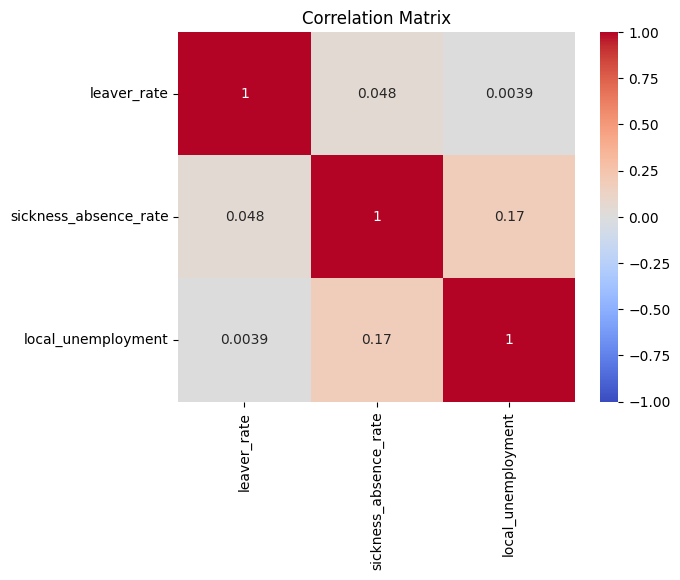

In [15]:
correlation_matrix = df_sg[['leaver_rate', 'sickness_absence_rate', 'local_unemployment']].corr()
# Create correlation matrix heatmap using Seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

(Optional) Create dummy variables for categorical independent variables

In [16]:
#df_with_dummies = pd.get_dummies(df_leaver, columns=ivs_cat, drop_first=True)
#df_with_dummies.head()

Specify the dependent variable (dv) and independent variables (ivs). All other fields to be dropped. 

In [17]:
dv = 'leaver_rate'
ivs = ['local_unemployment','sickness_absence_rate']
to_drop = ['Date','Org code','Org name','NHSE region name','NHSE region code','Cluster group','Benchmark group',
           'Staff group', 'FTE_Denoms', 'FTE_Leavers', 'FTE_Joiners','HC_Denoms','HC_Leavers','HC_Joiners','FTE days lost','FTE days available', dv]

Define the design matrix (X) and the dependent variable (y)


In [18]:
df_sg.reset_index(drop = True)
X = df_sg.drop(to_drop, axis=1)
y = df_sg[dv]

#y = y.dropna()

y.head()


6     0.0
24    0.0
25    0.0
41    0.0
57    0.0
Name: leaver_rate, dtype: float64

In [19]:
#X = X.dropna()

# Add a constant column to the design matrix
X = sm.add_constant(X)

X.tail()

# Convert True/False categories to integer 0/1
#bool_columns = X.select_dtypes(include='bool').columns
#X[bool_columns] = X[bool_columns].astype(int)


,const,local_unemployment,sickness_absence_rate
180230,1.0,0.039,0.0
180241,1.0,0.047,0.0
180251,1.0,0.039,0.0
180266,1.0,0.051,0.0
180267,1.0,0.037,0.0


In [20]:
# Fit the regression model
model = sm.OLS(y, X)
results = model.fit()

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            leaver_rate   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     17.37
Date:                Thu, 13 Jul 2023   Prob (F-statistic):           2.91e-08
Time:                        14:42:47   Log-Likelihood:                 44052.
No. Observations:               15157   AIC:                        -8.810e+04
Df Residuals:                   15154   BIC:                        -8.808e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.01

In [21]:

# Get the summary of the regression results
summary = results.summary()

# # Convert the summary table to a pandas DataFrame
# summary_df = pd.read_html(summary.tables[1].as_html(), header=0, index_col=0)[0]

# # Format the coefficients and p-values
# summary_df['coef'] = summary_df['coef'].map('{:.4f}'.format)
# summary_df['P>|t|'] = summary_df['P>|t|'].map('{:.4f}'.format)

# Print the formatted summary table
print(summary.tables[1])

                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.0116      0.001     22.408      0.000       0.011       0.013
local_unemployment       -0.0064      0.012     -0.544      0.586      -0.030       0.017
sickness_absence_rate     0.0252      0.004      5.875      0.000       0.017       0.034


This model uses region and type of provider to try and predict NHS staff leaver FTE. The R squared is 0.054, meaning the factors in the model only explain 5.4% of the variation in the data. A lower adjusted R squared than R squared would tell us that some of the model's factors are not contibuting - this is not the case here. 
All variables contribute significantly except being in the Midlands region, NE and Yorkshire, North West or South West.  
The strongest predictors are CCG